In [1]:
import os
import csv
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim 
from torchvision import transforms, datasets
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
from datetime import datetime
import torchvision.models as models


In [2]:
# 画像のサイズ
IMG_SIZE = 224

# データのディレクトリのパス
FLOWER_DIR = '../input/flowers'

batch_size = 32

model_name = "EfficientNetv2s"

In [3]:
# GPUが利用可能かどうかを確認し、利用可能ならGPUを使用
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')


Using device: cuda


# データセットの作成

In [4]:
transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)), # 画像サイズをリサイズ,
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# データセットを作成
dataset = datasets.ImageFolder(FLOWER_DIR, transform=transforms)


In [5]:
# 学習データに使用する割合
n_train_ratio = 0.8

# 割合から個数を出す
n_train = int(len(dataset) * n_train_ratio)
n_val   = int(len(dataset) - n_train)


In [6]:
# 学習データと検証データに分割
train, val = random_split(dataset, [n_train, n_val])


In [7]:
# Data Loader
train_loader = DataLoader(train, batch_size, shuffle=True, drop_last=True, num_workers=2)
val_loader = DataLoader(val, batch_size, num_workers=2)


In [8]:

class CustomEfficientNet(nn.Module):
    def __init__(self, num_classes):
        super(CustomEfficientNet, self).__init__()
        self.efficientnet = models.efficientnet_v2_s(weights="IMAGENET1K_V1") 
        in_features = self.efficientnet.classifier[1].in_features
        self.efficientnet.classifier[1] = nn.Linear(in_features, num_classes)  # 新しい最終層を追加

    def forward(self, x):
        return self.efficientnet(x)


In [9]:
# 2. モデルの構築
model = CustomEfficientNet(num_classes=5).to(device)


In [10]:
# 3. 訓練と検証
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5)



In [11]:
def train_and_evaluate_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=50):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        # 訓練フェーズ
        model.train()
        train_loss, train_correct = 0, 0
        for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}, Training...'):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad(set_to_none=True)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            train_correct += (predicted == labels).sum().item()

        # 検証フェーズ
        model.eval()
        val_loss, val_correct = 0, 0
        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs}, Validation...'):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_correct += (predicted == labels).sum().item()

        # 損失と精度の計算
        train_losses.append(train_loss / len(train_loader))
        val_losses.append(val_loss / len(val_loader))
        train_accuracies.append(train_correct / len(train_loader.dataset))
        val_accuracies.append(val_correct / len(val_loader.dataset))

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]}, Val Loss: {val_losses[-1]}, Train Acc: {train_accuracies[-1]}, Val Acc: {val_accuracies[-1]}')

    return train_losses, val_losses, train_accuracies, val_accuracies


In [12]:
train_losses, val_losses, train_accuracies, val_accuracies = train_and_evaluate_model(model, train_loader, val_loader, criterion, optimizer)


Epoch 1/50, Validation...: 100%|██████████| 27/27 [00:02<00:00, 12.57it/s]


Epoch 1/50, Train Loss: 0.5501206962861748, Val Loss: 1.0269903915899772, Train Acc: 0.810020272227049, Val Acc: 0.8055555555555556


Epoch 2/50, Validation...: 100%|██████████| 27/27 [00:02<00:00, 12.52it/s]


Epoch 2/50, Train Loss: 0.3693781167825806, Val Loss: 0.37570834546177473, Train Acc: 0.8586736171445121, Val Acc: 0.8668981481481481


Epoch 3/50, Validation...: 100%|██████████| 27/27 [00:02<00:00, 12.48it/s]


Epoch 3/50, Train Loss: 0.30214983183089816, Val Loss: 0.2838531880191079, Train Acc: 0.8942948161019404, Val Acc: 0.9004629629629629


Epoch 4/50, Validation...: 100%|██████████| 27/27 [00:02<00:00, 12.42it/s]


Epoch 4/50, Train Loss: 0.2326234783280954, Val Loss: 0.298668187663511, Train Acc: 0.9131190269331017, Val Acc: 0.8958333333333334


Epoch 5/50, Validation...: 100%|██████████| 27/27 [00:02<00:00, 12.52it/s]


Epoch 5/50, Train Loss: 0.19100178356900394, Val Loss: 0.2936257762765443, Train Acc: 0.9241239501882421, Val Acc: 0.9004629629629629


Epoch 6/50, Validation...: 100%|██████████| 27/27 [00:02<00:00, 12.41it/s]


Epoch 6/50, Train Loss: 0.20977964370607216, Val Loss: 0.2663792280687226, Train Acc: 0.9215175209962352, Val Acc: 0.9120370370370371


Epoch 7/50, Validation...: 100%|██████████| 27/27 [00:02<00:00, 12.52it/s]


Epoch 7/50, Train Loss: 0.1385188261830361, Val Loss: 0.3032457504283499, Train Acc: 0.9464233999420794, Val Acc: 0.9074074074074074


Epoch 8/50, Validation...: 100%|██████████| 27/27 [00:02<00:00, 12.44it/s]


Epoch 8/50, Train Loss: 0.1688172182190084, Val Loss: 0.27267191086516335, Train Acc: 0.9391833188531712, Val Acc: 0.9143518518518519


Epoch 9/50, Validation...: 100%|██████████| 27/27 [00:02<00:00, 12.51it/s]


Epoch 9/50, Train Loss: 0.14812721916100133, Val Loss: 0.30922774466927405, Train Acc: 0.9400521285838401, Val Acc: 0.9085648148148148


Epoch 10/50, Validation...: 100%|██████████| 27/27 [00:02<00:00, 12.43it/s]


Epoch 10/50, Train Loss: 0.12730827330498495, Val Loss: 0.3318689776308559, Train Acc: 0.9490298291340863, Val Acc: 0.9039351851851852


Epoch 11/50, Validation...: 100%|██████████| 27/27 [00:02<00:00, 12.51it/s]


Epoch 11/50, Train Loss: 0.13136237358378472, Val Loss: 0.3435296981974884, Train Acc: 0.9464233999420794, Val Acc: 0.8981481481481481


Epoch 12/50, Validation...: 100%|██████████| 27/27 [00:02<00:00, 12.40it/s]


Epoch 12/50, Train Loss: 0.10126920398237689, Val Loss: 0.2862311167021592, Train Acc: 0.9600347523892268, Val Acc: 0.9201388888888888


Epoch 13/50, Validation...: 100%|██████████| 27/27 [00:02<00:00, 12.42it/s]


Epoch 13/50, Train Loss: 0.10470379834176502, Val Loss: 0.28892042405075496, Train Acc: 0.9519258615696495, Val Acc: 0.9259259259259259


Epoch 14/50, Validation...: 100%|██████████| 27/27 [00:02<00:00, 12.31it/s]


Epoch 14/50, Train Loss: 0.09829575318199034, Val Loss: 0.2911486462862403, Train Acc: 0.9620619750941211, Val Acc: 0.9131944444444444


Epoch 15/50, Validation...: 100%|██████████| 27/27 [00:02<00:00, 12.29it/s]


Epoch 15/50, Train Loss: 0.10650434857669556, Val Loss: 0.31518090750884126, Train Acc: 0.9551114972487692, Val Acc: 0.9247685185185185


Epoch 16/50, Validation...: 100%|██████████| 27/27 [00:02<00:00, 12.40it/s]


Epoch 16/50, Train Loss: 0.11168508963206801, Val Loss: 0.3217551603361412, Train Acc: 0.9562699102229945, Val Acc: 0.8969907407407407


Epoch 17/50, Validation...: 100%|██████████| 27/27 [00:02<00:00, 12.56it/s]


Epoch 17/50, Train Loss: 0.10797784836075017, Val Loss: 0.2041909809189814, Train Acc: 0.9542426875181002, Val Acc: 0.9375


Epoch 18/50, Validation...: 100%|██████████| 27/27 [00:02<00:00, 12.48it/s]


Epoch 18/50, Train Loss: 0.08130957358560273, Val Loss: 0.27436220252679455, Train Acc: 0.963799594555459, Val Acc: 0.9120370370370371


Epoch 19/50, Validation...: 100%|██████████| 27/27 [00:02<00:00, 12.49it/s]


Epoch 19/50, Train Loss: 0.08579172752580005, Val Loss: 0.2744333373072247, Train Acc: 0.963799594555459, Val Acc: 0.9212962962962963


Epoch 20/50, Validation...: 100%|██████████| 27/27 [00:02<00:00, 12.42it/s]


Epoch 20/50, Train Loss: 0.07849844644350984, Val Loss: 0.27423506713023893, Train Acc: 0.9649580075296843, Val Acc: 0.9178240740740741


Epoch 21/50, Validation...: 100%|██████████| 27/27 [00:02<00:00, 12.50it/s]


Epoch 21/50, Train Loss: 0.0404112207932859, Val Loss: 0.2869445576022069, Train Acc: 0.9791485664639444, Val Acc: 0.9178240740740741


Epoch 22/50, Validation...: 100%|██████████| 27/27 [00:02<00:00, 12.44it/s]


Epoch 22/50, Train Loss: 0.06445377961749855, Val Loss: 0.3253077888792312, Train Acc: 0.9710396756443672, Val Acc: 0.9143518518518519


Epoch 23/50, Validation...: 100%|██████████| 27/27 [00:02<00:00, 11.98it/s]


Epoch 23/50, Train Loss: 0.08739122922671523, Val Loss: 0.29530902041329277, Train Acc: 0.9626411815812337, Val Acc: 0.9166666666666666


Epoch 24/50, Validation...: 100%|██████████| 27/27 [00:02<00:00, 12.15it/s]


Epoch 24/50, Train Loss: 0.09203621437424951, Val Loss: 0.42710760456544383, Train Acc: 0.9603243556327831, Val Acc: 0.8854166666666666


Epoch 25/50, Validation...: 100%|██████████| 27/27 [00:02<00:00, 12.25it/s]


Epoch 25/50, Train Loss: 0.08625170627661119, Val Loss: 0.29216479335877077, Train Acc: 0.964668404286128, Val Acc: 0.9131944444444444


Epoch 26/50, Validation...: 100%|██████████| 27/27 [00:02<00:00, 12.16it/s]


Epoch 26/50, Train Loss: 0.0619692988715474, Val Loss: 0.34578559561460104, Train Acc: 0.9727772951057052, Val Acc: 0.90625


Epoch 27/50, Validation...: 100%|██████████| 27/27 [00:02<00:00, 12.27it/s]


Epoch 27/50, Train Loss: 0.05742977250032301, Val Loss: 0.30929579947971636, Train Acc: 0.9733565015928178, Val Acc: 0.9259259259259259


Epoch 28/50, Validation...: 100%|██████████| 27/27 [00:02<00:00, 12.25it/s]


Epoch 28/50, Train Loss: 0.045748889365203015, Val Loss: 0.4013681254453129, Train Acc: 0.9748045178105995, Val Acc: 0.9004629629629629


Epoch 29/50, Validation...: 100%|██████████| 27/27 [00:02<00:00, 12.23it/s]


Epoch 29/50, Train Loss: 0.04962287316801653, Val Loss: 0.35026595760481777, Train Acc: 0.9762525340283811, Val Acc: 0.9212962962962963


Epoch 30/50, Validation...: 100%|██████████| 27/27 [00:02<00:00, 12.21it/s]


Epoch 30/50, Train Loss: 0.061143326600273704, Val Loss: 0.3419146521396383, Train Acc: 0.9716188821314798, Val Acc: 0.9166666666666666


Epoch 31/50, Validation...: 100%|██████████| 27/27 [00:02<00:00, 12.18it/s]


Epoch 31/50, Train Loss: 0.06051646171694743, Val Loss: 0.5733035309585156, Train Acc: 0.9730668983492615, Val Acc: 0.8854166666666666


Epoch 32/50, Validation...: 100%|██████████| 27/27 [00:02<00:00, 12.11it/s]


Epoch 32/50, Train Loss: 0.060945089753590975, Val Loss: 0.41695636683316145, Train Acc: 0.9710396756443672, Val Acc: 0.8981481481481481


Epoch 33/50, Validation...: 100%|██████████| 27/27 [00:02<00:00, 12.18it/s]


Epoch 33/50, Train Loss: 0.062289024841379825, Val Loss: 0.33337743383728796, Train Acc: 0.9701708659136983, Val Acc: 0.9236111111111112


Epoch 34/50, Validation...: 100%|██████████| 27/27 [00:02<00:00, 12.14it/s]


Epoch 34/50, Train Loss: 0.057757831841193694, Val Loss: 0.38706110252274406, Train Acc: 0.9719084853750362, Val Acc: 0.9085648148148148


Epoch 35/50, Validation...: 100%|██████████| 27/27 [00:02<00:00, 12.04it/s]


Epoch 35/50, Train Loss: 0.056111492268810764, Val Loss: 0.24316293496155628, Train Acc: 0.9736461048363741, Val Acc: 0.9247685185185185


Epoch 36/50, Validation...: 100%|██████████| 27/27 [00:02<00:00, 12.20it/s]


Epoch 36/50, Train Loss: 0.047626537526522496, Val Loss: 0.3080053926893958, Train Acc: 0.9765421372719374, Val Acc: 0.9155092592592593


Epoch 37/50, Validation...: 100%|██████████| 27/27 [00:02<00:00, 12.16it/s]


Epoch 37/50, Train Loss: 0.03753471201357528, Val Loss: 0.34298557084467673, Train Acc: 0.9797277729510571, Val Acc: 0.9155092592592593


Epoch 38/50, Validation...: 100%|██████████| 27/27 [00:02<00:00, 12.08it/s]


Epoch 38/50, Train Loss: 0.06663371949613303, Val Loss: 0.37434837763646134, Train Acc: 0.9701708659136983, Val Acc: 0.9270833333333334


Epoch 39/50, Validation...: 100%|██████████| 27/27 [00:02<00:00, 12.24it/s]


Epoch 39/50, Train Loss: 0.09813413226750688, Val Loss: 0.26358138659486063, Train Acc: 0.9623515783376774, Val Acc: 0.9189814814814815


Epoch 40/50, Validation...: 100%|██████████| 27/27 [00:02<00:00, 12.12it/s]


Epoch 40/50, Train Loss: 0.03874529907033805, Val Loss: 0.30663342787711706, Train Acc: 0.9803069794381697, Val Acc: 0.9178240740740741


Epoch 41/50, Validation...: 100%|██████████| 27/27 [00:02<00:00, 12.25it/s]


Epoch 41/50, Train Loss: 0.03408651360012504, Val Loss: 0.2897532946695315, Train Acc: 0.9803069794381697, Val Acc: 0.9201388888888888


Epoch 42/50, Validation...: 100%|██████████| 27/27 [00:02<00:00, 12.05it/s]


Epoch 42/50, Train Loss: 0.038859462230188865, Val Loss: 0.367456145239649, Train Acc: 0.9788589632203881, Val Acc: 0.9270833333333334


Epoch 43/50, Validation...: 100%|██████████| 27/27 [00:02<00:00, 12.36it/s]


Epoch 43/50, Train Loss: 0.0423003865099103, Val Loss: 0.347579763184681, Train Acc: 0.9782797567332754, Val Acc: 0.9050925925925926


Epoch 44/50, Validation...: 100%|██████████| 27/27 [00:02<00:00, 12.03it/s]


Epoch 44/50, Train Loss: 0.03618213972082213, Val Loss: 0.2627666833362094, Train Acc: 0.981465392412395, Val Acc: 0.9224537037037037


Epoch 45/50, Validation...: 100%|██████████| 27/27 [00:02<00:00, 12.49it/s]


Epoch 45/50, Train Loss: 0.03584820216616276, Val Loss: 0.42165402854206385, Train Acc: 0.9797277729510571, Val Acc: 0.8935185185185185


Epoch 46/50, Validation...: 100%|██████████| 27/27 [00:02<00:00, 11.85it/s]


Epoch 46/50, Train Loss: 0.06626729009385769, Val Loss: 0.4452884193095896, Train Acc: 0.9690124529394729, Val Acc: 0.90625


Epoch 47/50, Validation...: 100%|██████████| 27/27 [00:02<00:00, 12.14it/s]


Epoch 47/50, Train Loss: 0.06590269961955775, Val Loss: 0.46340664358878575, Train Acc: 0.9687228496959166, Val Acc: 0.8969907407407407


Epoch 48/50, Validation...: 100%|██████████| 27/27 [00:02<00:00, 12.12it/s]


Epoch 48/50, Train Loss: 0.09435048406273475, Val Loss: 0.4803163868685563, Train Acc: 0.9635099913119027, Val Acc: 0.8796296296296297


Epoch 49/50, Validation...: 100%|██████████| 27/27 [00:02<00:00, 12.09it/s]


Epoch 49/50, Train Loss: 0.05140894628945895, Val Loss: 0.33732919908922027, Train Acc: 0.9739357080799305, Val Acc: 0.9270833333333334


Epoch 50/50, Validation...: 100%|██████████| 27/27 [00:02<00:00, 12.10it/s]

Epoch 50/50, Train Loss: 0.037844980281351186, Val Loss: 0.3772769654342146, Train Acc: 0.9794381697075007, Val Acc: 0.9097222222222222


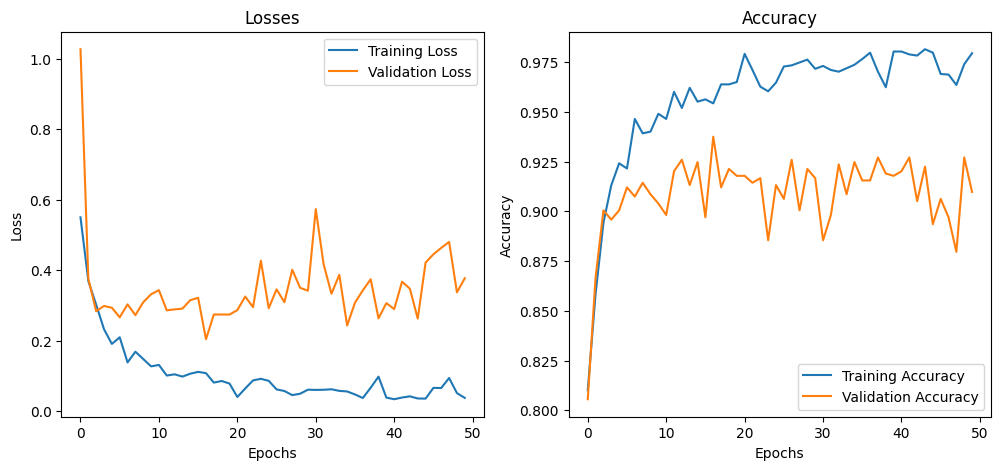

In [14]:
# グラフを保存するディレクトリを作成
output_dir = '../results'
os.makedirs(output_dir, exist_ok=True)

# タイムスタンプを生成
timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

# LossとAccuracyのデータをCSVファイルに保存
csv_filename = os.path.join(output_dir, f'{model_name}_{timestamp}.csv')
with open(csv_filename, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Epoch', 'Training Loss', 'Validation Loss', 'Training Accuracy', 'Validation Accuracy'])
    
    for epoch in range(len(train_losses)):
        writer.writerow([epoch+1, train_losses[epoch], val_losses[epoch], train_accuracies[epoch], val_accuracies[epoch]])


# Lossのグラフを保存
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title(f'Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracyのグラフを保存
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title(f'Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# 画像を保存
plt.savefig(os.path.join(output_dir, f'{model_name}_{timestamp}.png'))

# 画像を表示
plt.show()
